# Resample Data and Concatenate Channels

Informative as it is, raw Neon data is not always easy to work with. Different data streams (e.g., gaze, eye states, IMU) are sampled at different rates, don't necessarily share a common start timestamp, and within each stream data might not have been sampled at a constant rate. This tutorial demonstrates how to deal with these issues by resampling data streams and concatenating them into a single DataFrame.

We will use the same ``OfficeWalk`` dataset as in the [previous tutorial](read_recording.ipynb).

In [1]:
import numpy as np
from pyneon import get_sample_data, NeonRecording

import matplotlib.pyplot as plt
import seaborn as sns

recording_dir = get_sample_data("OfficeWalk") / "Timeseries Data" / "walk1-e116e606"

We can now access raw data from gaze, eye states, and IMU streams.

In [2]:
recording = NeonRecording(recording_dir)
gaze = recording.gaze
eye_states = recording.eye_states
imu = recording.imu

## Unequally sampled data

Data from each stream has `timestamp [ns]` and `time [s]` columns, which denotes the UTC time of the sample in nanoseconds and the relative time since stream onset in seconds, respectively. But are they equally spaced in time? Let's explore that by computing the time differences between consecutive samples for each stream and check how many unique values we have. If the data was sampled at a constant rate, we should have only one unique value.

In [5]:
# Get the data points
gaze_times = gaze.data["timestamp [ns]"].values
eye_states_times = eye_states.data["timestamp [ns]"].values
imu_times = imu.data["timestamp [ns]"].values

# Calculate the distances between subsequent data points
gaze_diffs = np.diff(gaze_times)
eye_states_diffs = np.diff(eye_states_times)
imu_diffs = np.diff(imu_times)

# Unique values
gaze_unique_diffs = np.unique(gaze_diffs)
eye_states_unique_diffs = np.unique(eye_states_diffs)
imu_unique_diffs = np.unique(imu_diffs)

print(f"Unique gaze time differences: {len(gaze_unique_diffs)}, max: {np.max(gaze_unique_diffs)/1e6}ms")
print(f"Unique eye states time differences: {len(eye_states_unique_diffs)}, max: {np.max(eye_states_unique_diffs)/1e6}ms")
print(f"Unique imu time differences: {len(imu_unique_diffs)}, max: {np.max(imu_unique_diffs)/1e6}ms")

Unique gaze time differences: 130, max: 115.123ms
Unique eye states time differences: 130, max: 115.123ms
Unique imu time differences: 1106, max: 230.444ms


Oops, it seems the data are far from being continuously sampled. We can further explore the distribution of such differences by plotting a histogram.

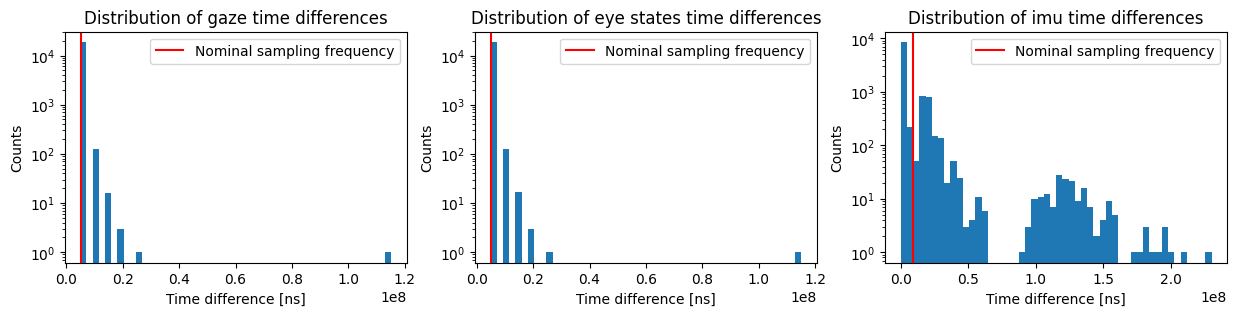

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

gaze_nominal_diff = 1e9 / gaze.sampling_freq_nominal
eye_states_nominal_diff = 1e9 / eye_states.sampling_freq_nominal
imu_nominal_diff = 1e9 / imu.sampling_freq_nominal

axs[0].hist(gaze_diffs, bins=50)
axs[0].axvline(gaze_nominal_diff, color="red", label="Nominal sampling frequency")
axs[0].set_title("Distribution of gaze time differences")
axs[1].hist(eye_states_diffs, bins=50)
axs[1].axvline(eye_states_nominal_diff, color="red", label="Nominal sampling frequency")
axs[1].set_title("Distribution of eye states time differences")
axs[2].hist(imu_diffs, bins=50)
axs[2].axvline(imu_nominal_diff, color="red", label="Nominal sampling frequency")
axs[2].set_title("Distribution of imu time differences")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].set_xlabel("Time difference [ns]")
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.show()

## Resampling data streams



Now, we concat the channels with a sampling frequency of 100 Hz. While this downsamples both imu and gaze, it will put them on a common reference frame. Under the hood, continuous values are linearly interpolated, whereas boolean values follow the nearest neighbour.

In [ ]:
concat_df = recording.concat_streams(["gaze", "eye_states", "imu"])

We show an exemplary sampling of eye, imu and concatenated data below. It can be seen that imu data has subsequent missing values which can in turn be interpolated

In [ ]:
start_time = 5
end_time = 5.2

raw_gaze_interval = gaze[
    (gaze["time [s]"] >= start_time) & (gaze["time [s]"] <= end_time)
]
raw_eye_states_interval = eye_states[
    (eye_states["time [s]"] > start_time)
    & (eye_states["time [s]"] <= end_time)
]
raw_imu_interval = imu[
    (imu["time [s]"] >= start_time) & (imu["time [s]"] <= end_time)
]
concat_interval = concat_df[
    (concat_df["time [s]"] >= start_time) & (concat_df["time [s]"] <= end_time)
]

# plot all data in the same scatter plot
plt.figure(figsize=(16, 2))
plt.scatter(
    raw_gaze_interval["time [s]"],
    np.zeros_like(raw_gaze_interval["time [s]"]) + 0.5,
    label="Raw gaze data",
    color="red",
)
plt.scatter(
    raw_imu_interval["time [s]"],
    np.zeros_like(raw_imu_interval["time [s]"]),
    label="Raw eye states data",
    color="blue",
)
plt.scatter(
    concat_interval["time [s]"],
    np.zeros_like(concat_interval["time [s]"]) - 1,
    label="Concatenated data",
    color="green",
)
# set x-ticks with higher frequency and add gridlines
plt.xticks(np.arange(start_time, end_time, 0.01), labels=None)
# remove x labels
# remove y-ticks
plt.yticks([])
plt.grid()
plt.legend()

A linear interpolation allows us to estimate missing values. In the end, the concatenated dataframe combines all continuous data into one central location

In [ ]:
# plot imu data and interpolated data in same plot


plt.figure(figsize=(16, 3))
plt.scatter(
    raw_imu_interval["time [s]"],
    raw_imu_interval["acceleration x [g]"],
    label="Raw imu data",
    color="blue",
)
plt.plot(
    concat_interval["time [s]"],
    concat_interval["acceleration x [g]"],
    label="Interpolated imu data",
    color="green",
    linestyle="dashed",
)
plt.legend()